In [53]:
import os
import json
import numpy as np
import pandas as pd
import bayesiantests as bt
from matplotlib import pyplot as plt

def combine_lists(lists):
    
    if len(lists) == 0:
        yield []
    else:
        for e in lists[0]:
            for sl in combine_lists(lists[1:]):
                yield [e] + sl
                
def fill(a, i):
    l = a.shape[0]
    if l-i < i:
        a[i:] = a[0:l-i]
        return a
    else:
        a[i:i+i] = a[0:i]
        return fill(a, i+i)

def compute_diff_matrix(a):
    a['val_loss_x'] = a.val_loss_x
    a['val_loss_y'] = a.val_loss_y
    a['perc'] = (a.val_loss_x - a.val_loss_y) / ((a.val_loss_x + a.val_loss_y) / 2)
    
    return a['perc'].values

    #a = a[a.val_loss_x <= a.val_loss_y]

    differences = []
    for n in a.noise.unique():
        differences.append(a[a.noise == n].perc.values)

    maxl = int(np.mean([d.shape[0] for d in differences]))

    dif = np.zeros((len(differences), maxl))
    for i, d in enumerate(differences):
        ri = min(maxl, d.shape[0])
        dif[i, 0:ri] = d[0:ri]

        if ri < maxl:
            dif[i] = fill(dif[i], ri)
    
    return dif
    
def parse_filename(name):
    parts = name.split("_")
    
    noise = parts[-3].replace("NL", "")
    ts = parts[-2].replace("DS", "")
    
    return noise, ts
    
    
TSLEN = 128
TSLENS = [TSLEN, 64]


DATASETS = ['ncmapss', 'pronostia', 'ecg5k', 'human_activity', 'wine', 'shares']
#DATASETS = ['ncmapss']
DENOISE_MODES = ['nr', 'dpm']
NETS = ['mscnn', 'bilstm']
COND = ['cond', 'nocond', 'noncond']
AUG = ['diff_aug', 'noise_aug', "raw_signals"]
TIMESTEPS = [0, 1,2,3]

MAX_LOSS = {
    'pronostia': 2,
    'ecg5k': 20,
    'ncmapss': 800,
    'human_activity': 20,
    'wine': 20,
    'shares': 4,
}

RESULTS = {}
results = []
iexperiment = 0
for ds in DATASETS:
    # 
    
    for tslen, net, aug, dm, cond in combine_lists([TSLENS, NETS, AUG, DENOISE_MODES, COND]):
        DATASET_DIR = f"../results/{ds}/{tslen}/"
        #print(DATASET_DIR)
        if len(list(os.walk(DATASET_DIR))) == 0:
            continue
            
        dirs = [d for d in list(os.walk(DATASET_DIR))[0][1] if d.startswith(f"{dm}_{cond}_{net}")]

        for experiment_dir in dirs:
            experiment_dir = os.path.join(DATASET_DIR, experiment_dir)
            iexperiment = experiment_dir[-1]
            experiment_files = [f for f in os.listdir(experiment_dir) if f.startswith(f"{net}_{aug}")]

            for file in experiment_files:
                
                noise, ts = parse_filename(file)

                history = json.load(open(os.path.join(experiment_dir, file), 'r'))
                
                if len(history['val_loss']) <= 6:
                    continue

        
                val_cols = [k for k in history.keys() if 'val_' in k]
                result = {
                    'tslen': tslen,
                    'ds': ds,
                    'net': net,
                    'aug': aug if ts != 0 else 'raw_signals',
                    'noise': float(noise),
                    'ts': ts,
                    'epochs': len(history['val_loss']),
                    'experiment': iexperiment,
                    'cond_diff': True if cond == 'cond' or aug in ['raw_signals', 'noise_aug'] else False,
                    'denoise_mode': 'ignored' if aug in ['raw_signals', 'noise_aug'] else dm,
                    'iexperiment': iexperiment,
                }
                for c in val_cols:
                    result[c] = history[c][-1]
                
                #if result['val_loss'] > MAX_LOSS[ds]:
                    #print(f"Discarted {experiment_dir}/{file}")
                #    continue
                    
                results.append(result)

r = pd.DataFrame(results)

r = r[~r.val_loss.isnull()]

pd.set_option('display.max_rows', 600)
group_cols = ["tslen", "ds", "net", "aug", "noise", "ts", "cond_diff", "denoise_mode"]

agg_columns = [k for k in history.keys() if 'val_' in k] + ['epochs']

r = r.groupby(group_cols)[agg_columns].agg(["mean", "std"])
columns_names = [[c, c + "_std"] for c in agg_columns]
columns_names = [c for cols in columns_names for c in cols]
r.columns = columns_names

r.loc[r.val_loss_std.isnull(), 'val_loss_std']= 0

base_df = r.reset_index().sort_values('val_loss')


In [54]:
minmax = base_df.groupby(['ds', 'net', 'aug', 'cond_diff', 'denoise_mode']).val_loss.aggregate(['min', 'max']).reset_index()
val_loss = base_df[['ds', 'net', 'aug', 'cond_diff', 'denoise_mode', 'val_loss', 'noise', 'ts']]

minmax.merge(val_loss, on=['ds', 'net', 'aug', 'cond_diff', 'denoise_mode']).to_csv('results.csv', index=False)

In [55]:
base_df[(base_df.ds == 'wine') & (base_df.net == 'mscnn') & (base_df.denoise_mode == 'dpm')]


,tslen,ds,net,aug,noise,ts,cond_diff,denoise_mode,val_loss,val_loss_std,val_accuracy,val_accuracy_std,epochs,epochs_std
3648,128,wine,mscnn,diff_aug,0.63,3,False,dpm,0.410039,0.024561,0.811094,0.006016,29.666667,1.154701
3709,128,wine,mscnn,diff_aug,1.79,1,False,dpm,0.442968,0.000000,0.801094,NaN,69.000000,NaN
3629,128,wine,mscnn,diff_aug,0.32,2,True,dpm,0.452899,0.000000,0.827109,NaN,29.000000,NaN
3650,128,wine,mscnn,diff_aug,0.74,1,False,dpm,0.453420,0.000000,0.822891,NaN,36.000000,NaN
3642,128,wine,mscnn,diff_aug,0.53,3,False,dpm,0.456417,0.062135,0.815260,0.006913,29.666667,8.386497
3657,128,wine,mscnn,diff_aug,0.84,2,False,dpm,0.459071,0.039090,0.821680,0.001050,30.000000,25.455844
3638,128,wine,mscnn,diff_aug,0.53,1,False,dpm,0.468579,0.009812,0.823594,0.005745,19.500000,6.363961
3665,128,wine,mscnn,diff_aug,0.95,3,False,dpm,0.480575,0.014450,0.821719,0.000000,15.000000,4.000000
3659,128,wine,mscnn,diff_aug,0.84,3,False,dpm,0.481622,0.017149,0.821719,0.000000,46.000000,39.597980
3654,128,wine,mscnn,diff_aug,0.74,3,False,dpm,0.483472,0.052537,0.821354,0.000631,30.666667,7.023769


In [56]:
group_cols = ["ds", "net", "aug", "denoise_mode"]

aux = base_df[base_df.cond_diff == True].groupby(group_cols).val_loss.min().reset_index()
aux = base_df[base_df.val_loss.isin(aux.val_loss.values)]
aux = aux[group_cols + ['val_loss', 'val_loss_std', 'ts']]
aux['mode'] = aux.denoise_mode
aux.loc[aux['mode'] == 'nr', 'mode'] = 'AE'
aux.loc[aux['mode'] == 'dpm', 'mode'] = 'DPM'
aux['val_loss'] = aux.val_loss.round(4)
aux['val_loss_std'] = aux.val_loss_std.round(4)
aux['ts'] = aux.ts.map(lambda x: f"[{x}]")
aux.loc[aux.aug == 'noise_aug', 'ts'] = ""
aux.loc[aux.aug == 'raw_signals', 'ts'] = ""

aux['loss'] = aux.val_loss.map(lambda x: f"{x:7.4f}" ) + ' ± ' + aux.val_loss_std.map(lambda x: f"{x:8.4f}" ) + ' ' + aux.ts

aux.loc[aux.aug == 'noise_aug', 'mode'] = 'Noise'
aux.loc[aux.aug == 'raw_signals', 'mode'] = 'Raw'
del aux['aug']
del aux['denoise_mode']
del aux['ts']
del aux['val_loss']
del aux['val_loss_std']
aux = aux.pivot(columns='mode', values=['loss'], index=['ds', 'net']).reset_index()
aux.columns = ['Dataset', 'Net', 'AE', 'DPM', 'Noise', 'Raw']
aux = aux[['Dataset', 'Net', 'Raw',  'AE', 'DPM']]
print(aux.to_latex(index=False))

aux

\begin{tabular}{lllll}
\toprule
       Dataset &    Net &                  Raw &                      AE &                     DPM \\
\midrule
         ecg5k & bilstm &   0.5211 ±   0.1178  &   0.3609 ±   0.0157 [1] &   0.3235 ±   0.0085 [1] \\
         ecg5k &  mscnn &   0.7591 ±   0.3981  &   0.5204 ±   0.0325 [3] &   0.4272 ±   0.0205 [1] \\
human\_activity & bilstm &   1.2370 ±   0.2486  &   1.1023 ±   0.0016 [1] &   1.0897 ±   0.0011 [2] \\
human\_activity &  mscnn &   1.2764 ±   0.1213  &   1.2015 ±   0.0314 [1] &   1.2758 ±   0.0120 [2] \\
       ncmapss & bilstm & 252.9270 ±  13.9745  & 242.1542 ±   0.0000 [2] & 246.7824 ±  16.9870 [2] \\
       ncmapss &  mscnn & 459.5337 ± 165.5178  & 324.1614 ±  16.9442 [2] & 266.0854 ±  13.5774 [1] \\
     pronostia & bilstm &   0.0720 ±   0.0063  &   0.0648 ±   0.0030 [3] &   0.0662 ±   0.0007 [1] \\
     pronostia &  mscnn &   0.0614 ±   0.0044  &   0.0487 ±   0.0030 [1] &   0.0522 ±   0.0029 [3] \\
        shares & bilstm &   0.3480 ±   

,Dataset,Net,Raw,AE,DPM
0,ecg5k,bilstm,0.5211 ± 0.1178,0.3609 ± 0.0157 [1],0.3235 ± 0.0085 [1]
1,ecg5k,mscnn,0.7591 ± 0.3981,0.5204 ± 0.0325 [3],0.4272 ± 0.0205 [1]
2,human_activity,bilstm,1.2370 ± 0.2486,1.1023 ± 0.0016 [1],1.0897 ± 0.0011 [2]
3,human_activity,mscnn,1.2764 ± 0.1213,1.2015 ± 0.0314 [1],1.2758 ± 0.0120 [2]
4,ncmapss,bilstm,252.9270 ± 13.9745,242.1542 ± 0.0000 [2],246.7824 ± 16.9870 [2]
5,ncmapss,mscnn,459.5337 ± 165.5178,324.1614 ± 16.9442 [2],266.0854 ± 13.5774 [1]
6,pronostia,bilstm,0.0720 ± 0.0063,0.0648 ± 0.0030 [3],0.0662 ± 0.0007 [1]
7,pronostia,mscnn,0.0614 ± 0.0044,0.0487 ± 0.0030 [1],0.0522 ± 0.0029 [3]
8,shares,bilstm,0.3480 ± 0.0266,0.3435 ± 0.0142 [3],0.2947 ± 0.0495 [1]
9,shares,mscnn,1.2505 ± 0.8296,0.3113 ± 0.0157 [3],0.2153 ± 0.0175 [3]


dpm 0.6514285714285715
1.0 0.0 0.0
nr 0.20743034055727555
0.0 0.0 1.0


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

1.0 0.0 0.0


array([0.2586866 , 0.31849205, 0.30035534, ..., 0.27018615, 0.37027309,
       0.25317842])

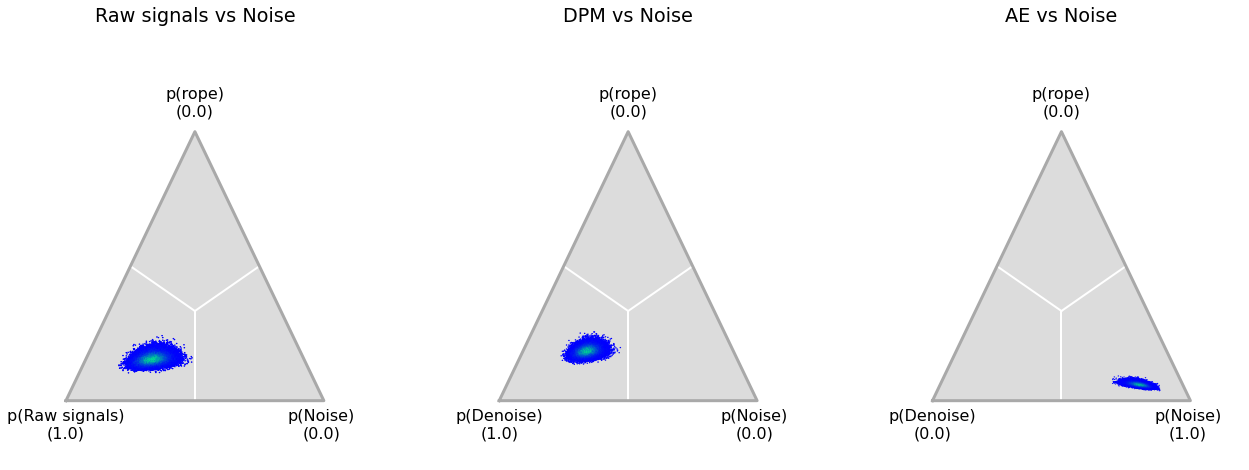

In [83]:
r = base_df

#r = r[(r.ds == 'ncmapss')]
rope = 0.05


noise_range = [0, 0.8]

figure, ax = plt.subplots(1, 3, sharex=False, figsize=(22,8))

titles = ['DPM vs Noise', 'AE vs Noise']
for i, dm  in enumerate(['dpm', 'nr'],1):
    cols = ['ds', 'net', 'noise', 'cond_diff', 'denoise_mode', 'val_loss']
    rd = r[(r.aug != 'raw_signals') & (r.aug != 'noise_aug') & (r.cond_diff)][cols]
    rr = r[(r.aug == 'noise_aug') & (r.noise > 0)][cols]

    rd = rd[rd.denoise_mode == dm]

    a = pd.merge(rd, rr, on=["ds", "net", "noise",  "cond_diff"])
    a = a[a.noise.map(lambda x: x > noise_range[0] and x < noise_range[1])]

    print(dm, (a.val_loss_x < a.val_loss_y).mean())     

    dif = compute_diff_matrix(a)


    names=['Denoise', 'Noise']
    samples, (pl, pe, pr) = bt.signrank_MC(dif, rope, prior_strength=0.6)
    #pl, pe, pr = bt.signrank(dif, rope)

    print(pl, pe, pr)



    bt.plot_posterior(ax[i],samples, (pl, pe, pr), names, triangle_color="darkgrey", 
                      points_cmap='winter', linewidth=3)

    ax[i].set_title(titles[i-1])



cols = ['ds', 'net', 'ts', 'val_loss']
rd = r[(r.aug == 'raw_signals')][cols]
cols = ['ds', 'net', 'noise', 'cond_diff', 'denoise_mode', 'val_loss']
rr = r[(r.aug == 'noise_aug')][cols]

a = pd.merge(rd, rr, on=["ds", "net"])
b = a
a = a[a.noise.map(lambda x: x > noise_range[0] and x < noise_range[1])]

dif = compute_diff_matrix(a)

names=['Raw signals', 'Noise']
samples, (pl, pe, pr) = bt.signrank_MC(dif,rope)
#pl, pe, pr = bt.signrank(dif,rope)

print(pl, pe, pr)

#rv = np.abs(np.random.normal(0, 0.03, size=(samples.shape[0],)))
#samples[:, 2] = samples[:, 2] + rv
#samples[:, 0] = samples[:, 0] - rv/2 
#samples[:, 1] = samples[:, 1] #- rv/2


bt.plot_posterior(ax[0],samples, (pl, pe, pr), names, triangle_color="darkgrey", 
                  points_cmap='winter', linewidth=3)

ax[0].set_title("Raw signals vs Noise")

plt.savefig('denoise_vs_noise.svg', facecolor="white", bbox_inches='tight')


samples[:, 2]

0.94944 0.0 0.05056
0.0 0.0 1.0


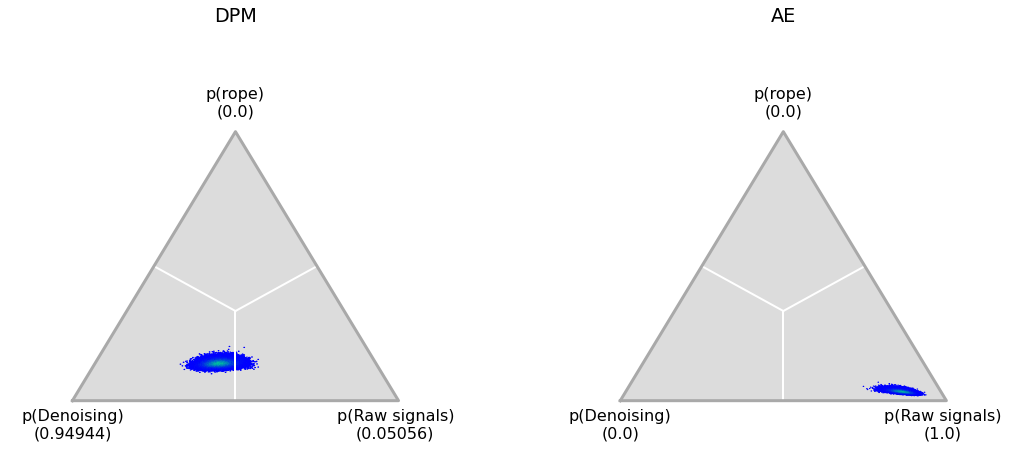

In [80]:
# DENOISE vs RAW MODEL
r = base_df

figure, ax = plt.subplots(1, 2, sharex=False, figsize=(18,8))

rope = 0.05
noise_range = [0, 0.8]
titles = ['DPM', 'AE']
for i, dm  in enumerate(['dpm', 'nr']):
    cols = ['ds', 'net', 'noise', 'cond_diff', 'denoise_mode', 'val_loss']
    rd = r[(r.aug != 'raw_signals') & (r.aug != 'noise_aug') & (r.cond_diff == True)][cols]
    cols = ['ds', 'net', 'ts', 'val_loss']
    rr = r[(r.aug == 'raw_signals')][cols]
    
    rd = rd[rd.denoise_mode == dm]

    a = pd.merge(rd, rr, on=["ds", "net"])

    a = a[a.noise.map(lambda x: x > noise_range[0] and x < noise_range[1])]

    dif = compute_diff_matrix(a)

    names=['Denoising', 'Raw signals']
    samples, (pl, pe, pr)=bt.signrank_MC(dif,rope)
 
    print(pl, pe, pr)

    rv = np.abs(np.random.normal(0, 0.06, size=(samples.shape[0],)))
    #samples[:, 2] = samples[:, 2] + rv
    #samples[:, 0] = samples[:, 0] - rv/2 
    #samples[:, 1] = samples[:, 1] + rv/2


    bt.plot_posterior(ax[i], samples, (pl, pe, pr), names, triangle_color="darkgrey", 
                      points_cmap='winter', linewidth=3)
    
    ax[i].set_title(titles[i])
  
plt.savefig('denoise_vs_raw.svg', facecolor="white", bbox_inches='tight')


0.0 0.0 1.0
0.99998 0.0 2e-05


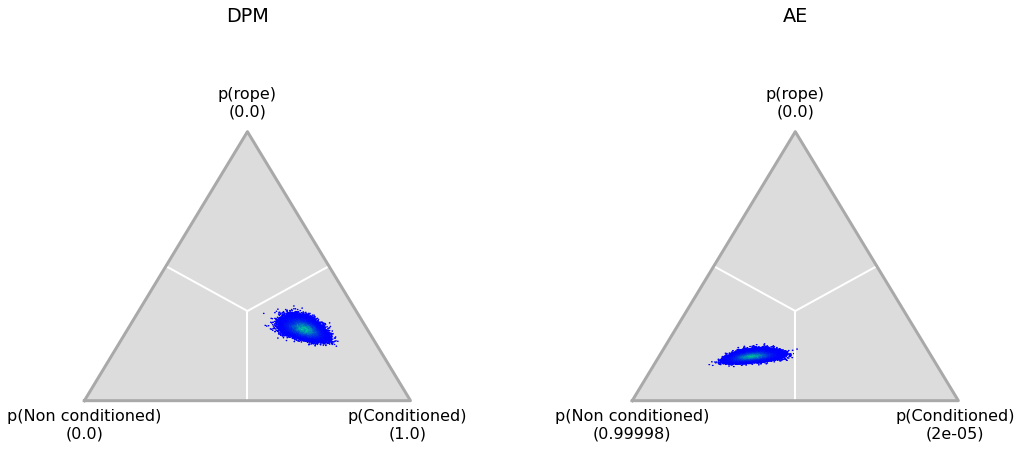

In [81]:
figure, ax = plt.subplots(1, 2, sharex=False, figsize=(18,8))


titles = ['DPM', 'AE']
for j, dm  in enumerate(['dpm', 'nr']):

    cols = ['ds', 'net', 'noise', 'denoise_mode', 'ts',  'val_loss']
    rd = r[(r.aug == 'diff_aug') & (r.cond_diff == False)][cols]
    rr = r[(r.aug == 'diff_aug') & (r.cond_diff == True)][cols]
    
    rd = rd[rd.denoise_mode == dm]
    
    a = pd.merge(rd, rr, on=["ds", "net", 'noise', 'ts', 'denoise_mode'])
    a = a[a.noise.map(lambda x: x > noise_range[0] and x < noise_range[1])]
    
    dif = compute_diff_matrix(a)
    
    samples, (pl, pe, pr)=bt.signrank_MC(dif, rope*2) 
    print(pl, pe, pr)


    fig = bt.plot_posterior(ax[j], samples, (pl, pe, pr), ["Non conditioned", "Conditioned"], 
                            triangle_color="darkgrey", points_cmap='winter', linewidth=3)
    
    ax[j].set_title(titles[j])
    
plt.savefig('noncond_vs_cond.svg', facecolor="white", bbox_inches='tight')


0.00032 0.0 0.99968
0.0 0.0 1.0


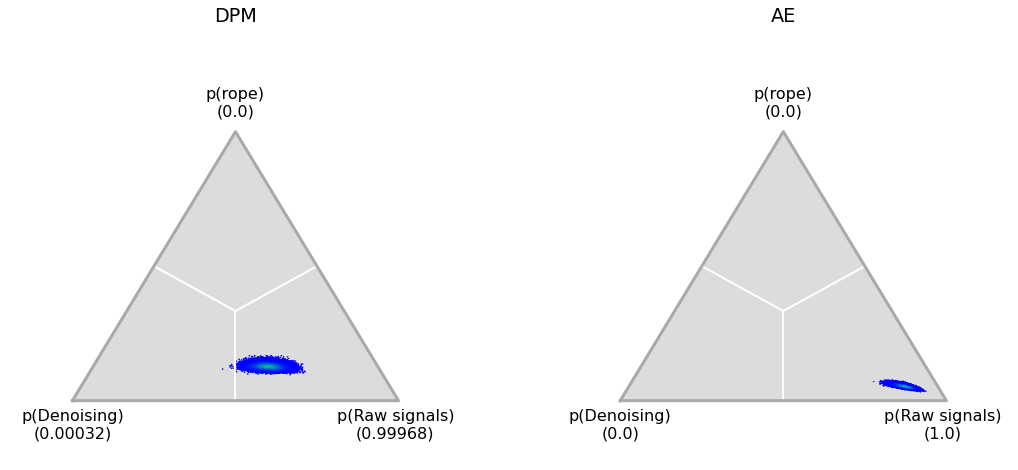

In [82]:
# DENOISE vs RAW MODEL
r = base_df

figure, ax = plt.subplots(1, 2, sharex=False, figsize=(18,8))

rope = 0.05
titles = ['DPM', 'AE']
for i, dm  in enumerate(['dpm', 'nr']):
    cols = ['ds', 'net', 'noise', 'cond_diff', 'denoise_mode', 'val_loss']
    rd = r[(r.aug != 'raw_signals') & (r.aug != 'noise_aug') & (r.cond_diff == False)][cols]
    cols = ['ds', 'net', 'ts', 'val_loss']
    rr = r[(r.aug == 'raw_signals')][cols]
    
    rd = rd[rd.denoise_mode == dm]

    a = pd.merge(rd, rr, on=["ds", "net"])
    a = a[a.noise.map(lambda x: x > noise_range[0] and x < noise_range[1])]

    dif = compute_diff_matrix(a)

    names=['Denoising', 'Raw signals']
    samples, (pl, pe, pr) = bt.signrank_MC(dif,rope)
    
    print(pl, pe, pr)

    rv = np.abs(np.random.normal(0, 0.02, size=(samples.shape[0],)))
    #samples[:, 2] = samples[:, 2] + rv
    #samples[:, 0] = samples[:, 0] - rv/2 
    #samples[:, 1] = samples[:, 1] #- rv/2


    bt.plot_posterior(ax[i], samples, (pl, pe, pr), names, triangle_color="darkgrey", 
                      points_cmap='winter', linewidth=3)
    
    ax[i].set_title(titles[i])
  
plt.savefig('uncond_denoising_vs_raw.svg', facecolor="white", bbox_inches='tight')

In [75]:
a[a.ds == 'ecg5k'].noise.unique()


array([0.05, 0.15, 0.35, 0.2 , 0.25, 0.1 , 0.5 , 0.6 , 0.45, 0.55, 0.3 ,
       0.4 ])

ncmapss
pronostia
ecg5k
human_activity
wine
shares


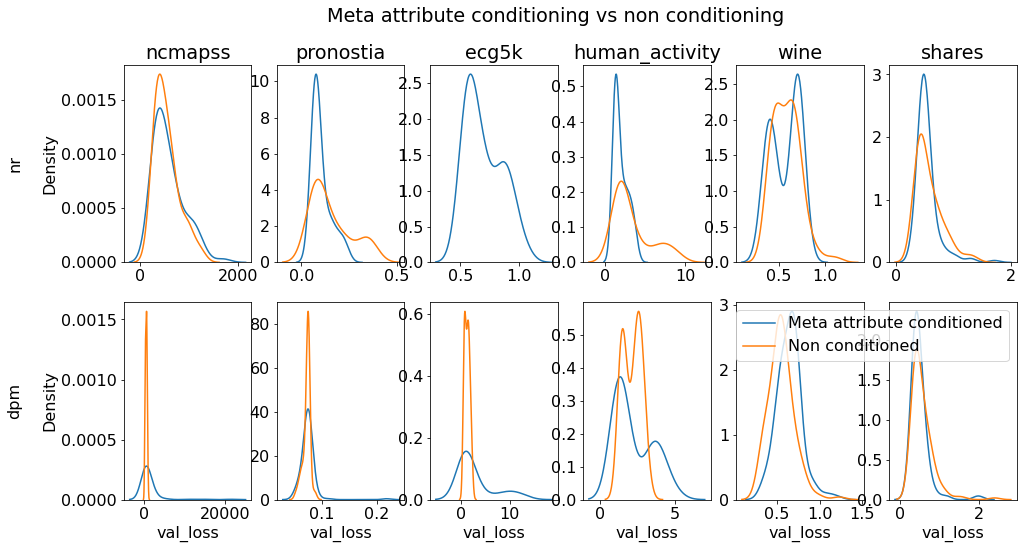

In [232]:
from matplotlib import pyplot as plt
import seaborn as sns


figure, axes = plt.subplots(2, len(DATASETS), sharex=False, figsize=(16,8))
figure.suptitle('Meta attribute conditioning vs non conditioning')
#figure.update_xaxes(matches=None, showticklabels=True)

for j, ds in enumerate(DATASETS):
    print(ds)
    for i, dm in enumerate(['nr', 'dpm']):
        mask = (r.ds == ds) & (r.denoise_mode == dm)
    
        sns.kdeplot(r[mask & (r.cond_diff) & (r.aug=='diff_aug')].val_loss, 
                    bw_method=0.5, label="Meta attribute conditioned",
                   ax=axes[i, j])
        sns.kdeplot(r[mask & (~r.cond_diff) & ( (r.aug=='diff_aug'))].val_loss, 
                    bw_method=0.5, label="Non conditioned",
                    ax=axes[i, j]
                   )
        
        if i == 0:
            axes[i, j].get_xaxis().set_label_text('')
            axes[i, j].set_title(ds)
            
        if j != 0:
            axes[i, j].get_yaxis().set_label_text('')
        else:
            axes[i, j].get_yaxis().set_label_text(f"{dm}\n\nDensity")
            
            
        
        
plt.legend()
plt.show()
        

ncmapss
pronostia
ecg5k
human_activity


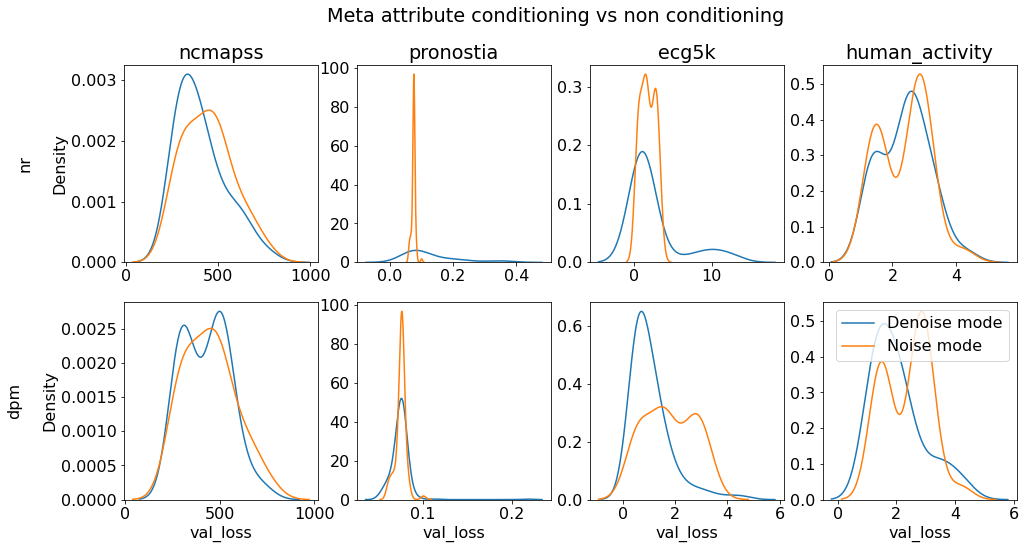

In [123]:
from matplotlib import pyplot as plt
import seaborn as sns


figure, axes = plt.subplots(2, len(DATASETS), sharex=False, figsize=(16,8))
figure.suptitle('Meta attribute conditioning vs non conditioning')
#figure.update_xaxes(matches=None, showticklabels=True)

for j, ds in enumerate(DATASETS):
    print(ds)
    for i, dm in enumerate(['nr', 'dpm']):
        mask = (r.ds == ds) 
    
        sns.kdeplot(r[mask & (r.denoise_mode == dm) & (r.aug=='diff_aug')].val_loss, 
                    bw_method=0.5, label="Denoise mode",
                   ax=axes[i, j])
        sns.kdeplot(r[mask & (r.aug=='noise_aug')].val_loss, 
                    bw_method=0.5, label="Noise mode",
                    ax=axes[i, j]
                   )
        
        if i == 0:
            axes[i, j].get_xaxis().set_label_text('')
            axes[i, j].set_title(ds)
            
        if j != 0:
            axes[i, j].get_yaxis().set_label_text('')
        else:
            axes[i, j].get_yaxis().set_label_text(f"{dm}\n\nDensity")
            
            
        
        
plt.legend()
plt.show()